Epoch 0
train loss 1.882771
test loss 8.606853

Epoch 1
train loss 1.739830
test loss 7.946254

Epoch 2
train loss 2.040645
test loss 8.048541

Epoch 3
train loss 2.082760
test loss 7.915755

Epoch 4
train loss 2.464628
test loss 7.951954

Epoch 5
train loss 1.864006
test loss 8.087570

Epoch 6
train loss 2.233498
test loss 7.662671

Epoch 7
train loss 2.085636
test loss 7.341256

Epoch 8
train loss 2.125613
test loss 7.479323

Epoch 9
train loss 1.732895
test loss 7.806537

Epoch 10
train loss 2.521281
test loss 8.130097

Epoch 11
train loss 2.207136
test loss 7.527033

Epoch 12
train loss 1.886706
test loss 7.985454

Epoch 13
train loss 1.922468
test loss 7.638771

Epoch 14
train loss 2.275837
test loss 8.202793

Epoch 15
train loss 2.305806
test loss 8.832422

Epoch 16
train loss 2.246752
test loss 8.386493

Epoch 17
train loss 2.191220
test loss 7.710367

Epoch 18
train loss 1.897222
test loss 7.568936

Epoch 19
train loss 1.917644
test loss 7.460131

Epoch 20
train loss 2.246920
t

ValueError: ignored

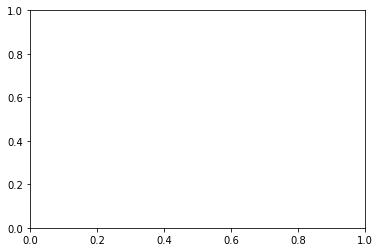

In [5]:
import random

import torch
import torch.nn as nn
import torch.utils.data as Dataset
import matplotlib.pyplot as plt


from torch.optim import lr_scheduler
import torch.optim as optim
from center_loss import CenterLoss

from torchvision import datasets, transforms
from torch import utils
# Data preparation
CUDA = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if CUDA else {}
batch_size = 128
learning_rate = 1e-3
epochs = 50


data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

dataset = datasets.ImageFolder('drive/MyDrive/ML_Sp21_Project/100_WebFace', transform=data_transform)
train_length = int(0.8 * len(dataset))
valid_length = len(dataset) - train_length
train, valid = utils.data.random_split(dataset=dataset, lengths=[train_length, valid_length])
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=True, **kwargs)


# Network Buildup
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.convnet = nn.Sequential(nn.Conv2d(3, 32, 5), nn.PReLU(), #32@24*24 32@108
                                     nn.MaxPool2d(2, stride=2), #32@12*12 32@54
                                     nn.Conv2d(32, 64, 5), nn.PReLU(), #64@8*8 32@50
                                     nn.MaxPool2d(2, stride=2)) #64*4*4 64@25

        self.fc = nn.Sequential(nn.Linear(64 * 25 * 25, 256),
                                nn.PReLU(),
                                nn.Linear(256, 256),
                                nn.PReLU(),
                                nn.Linear(256, 2)
                                )

    def forward(self, x):
        output = self.convnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def get_embedding(self, x):
        return self.forward(x)


# Define Contrastive Loss



model = EmbeddingNet()
if CUDA:
    model.cuda()
loss_function = CenterLoss(num_classes=100, feat_dim=2, use_gpu=CUDA)
optimizer = torch.optim.SGD(loss_function.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, 20, gamma=0.2)


epoches = []
test_losses = []
torch.cuda.empty_cache()
# Start Training
for epoch in range(epochs):
    print('Epoch {}'.format(epoch))
    for step, (batch_x, batch_y) in enumerate(train_loader):
        if CUDA:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
        embedding = model.forward(batch_x)
        loss = loss_function(embedding, batch_y)
        loss.backward()
        optimizer.step()
        scheduler.step()
    print('train loss {:.6f}'.format(loss))

    test_loss = 0
    for batch_x, batch_y in test_loader:
        if CUDA:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
        with torch.no_grad():
            embedding = model(batch_x)
        test_loss += loss_function(embedding, batch_y)
    test_losses.append(test_loss.item())
    epoches.append(epoch)
    print('test loss {:.6f}'.format(test_loss))
    print()
plt.plot(epoches, test_losses)
plt.savefig('test_loss.png')

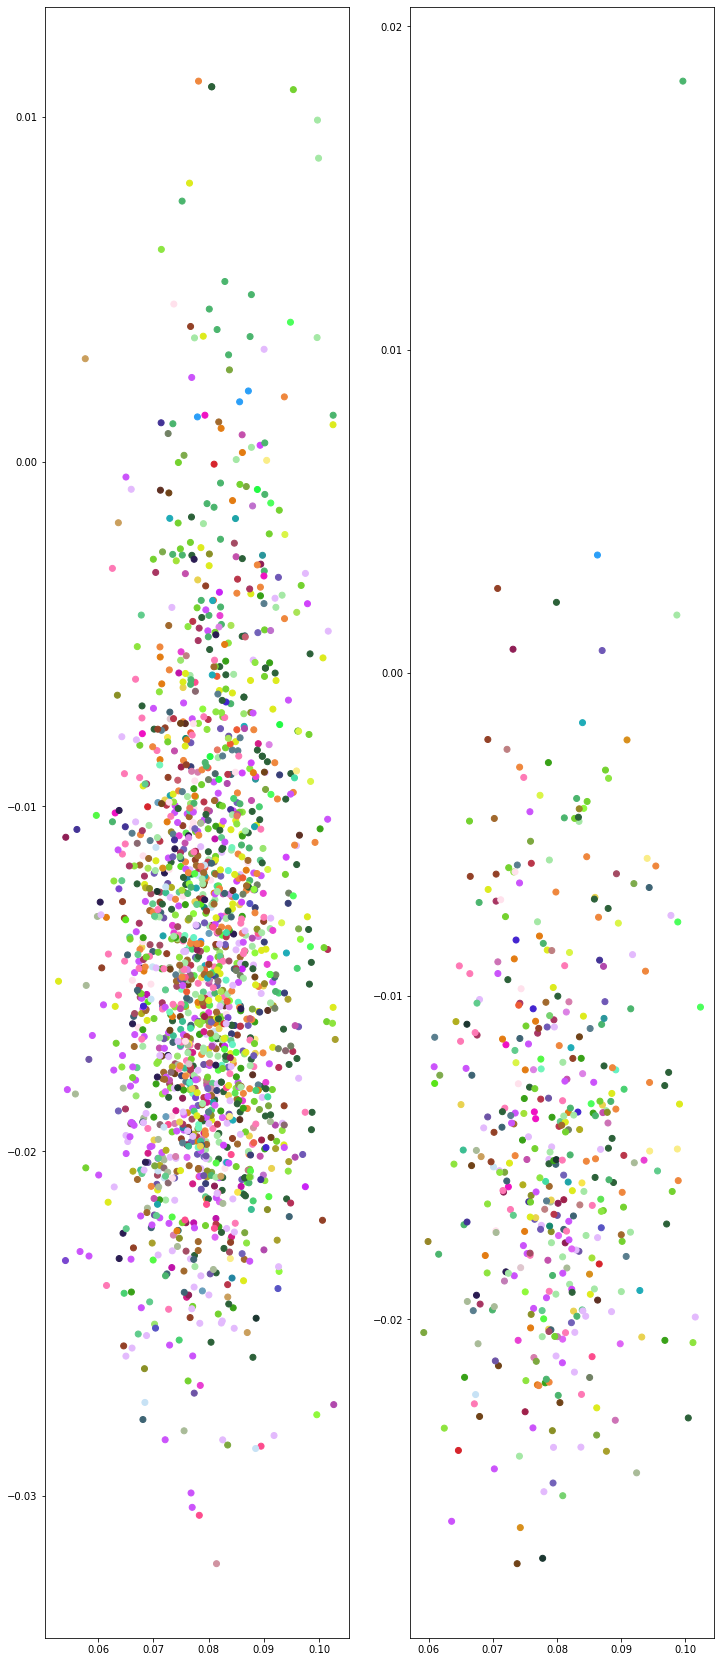

In [13]:
def getColor():
    color: int
    color1 = random.randint(16, 255)
    color2 = random.randint(16, 255)
    color3 = random.randint(16, 255)
    color1 = hex(color1)
    color2 = hex(color2)
    color3 = hex(color3)
    ans = "#" + color1[2:] + color2[2:] + color3[2:]
    return ans


colors = [getColor() for i in range(100)]
train_x = []
train_y = []
train_color = []
test_x = []
test_y = []
test_color = []


for (batch_x, batch_y) in train_loader:
    if CUDA:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
    with torch.no_grad():
        embedding = model(batch_x)
    # print(embedding)
    for i in range(embedding.shape[0]):
        train_x.append(embedding[i][0].item())
        train_y.append(embedding[i][1].item())
        train_color.append(colors[batch_y[i].item()])



for (batch_x, batch_y) in test_loader:
    if CUDA:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
    with torch.no_grad():
        embedding = model(batch_x)
    # print(embedding)
    for i in range(embedding.shape[0]):
        test_x.append(embedding[i][0].item())
        test_y.append(embedding[i][1].item())
        test_color.append(colors[batch_y[i].item()])

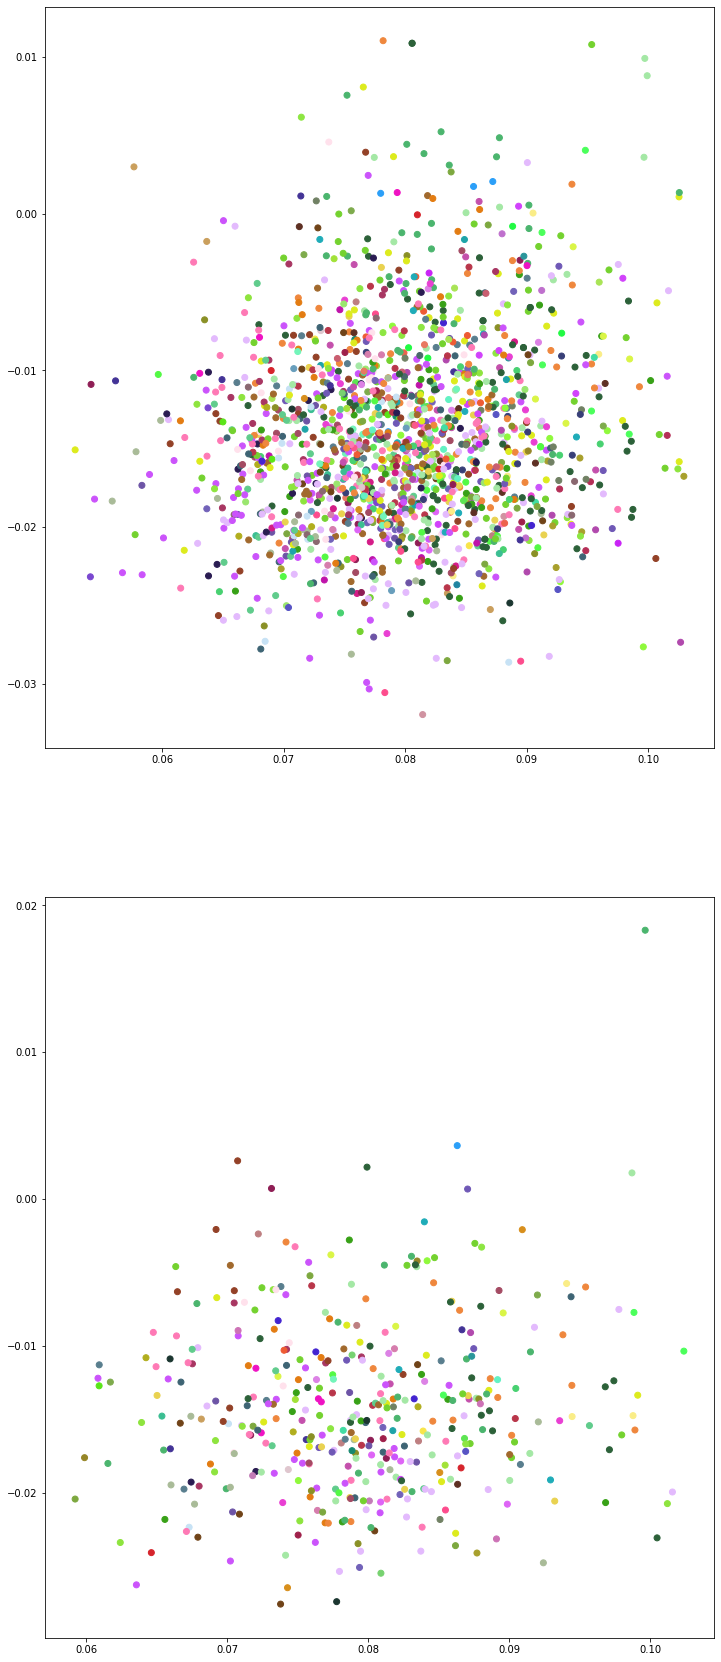

In [14]:
plt.figure(figsize=(12, 30))
plt.subplot(2, 1, 1)
plt.scatter(train_x, train_y, c=train_color)
plt.savefig('train.png')
plt.subplot(2, 1, 2)
plt.scatter(test_x, test_y, c=test_color)
plt.savefig('test.png')